In [2]:
import numpy as np
from io import StringIO
import os
import matplotlib.pyplot as plt
import joblib

In [12]:
#The model was trained using these r-values in [1/GeV]. You need to define your dipole on this r-grid:
r_values = [
    1.01000000e-06, 1.21200000e-06, 1.45440000e-06, 1.74528000e-06,
    2.09433600e-06, 2.51320320e-06, 3.01584384e-06, 3.61901261e-06,
    4.34281513e-06, 5.21137816e-06, 6.25365379e-06, 7.50438454e-06,
    9.00526145e-06, 1.08063137e-05, 1.29675765e-05, 1.55610918e-05,
    1.86733102e-05, 2.24079722e-05, 2.68895666e-05, 3.22674799e-05,
    3.87209759e-05, 4.64651711e-05, 5.57582053e-05, 6.69098464e-05,
    8.02918157e-05, 9.63501788e-05, 1.15620215e-04, 1.38744257e-04,
    1.66493109e-04, 1.99791731e-04, 2.39750077e-04, 2.87700092e-04,
    3.45240111e-04, 4.14288133e-04, 4.97145760e-04, 5.96574911e-04,
    7.15889894e-04, 8.59067873e-04, 1.03088145e-03, 1.23705774e-03,
    1.48446928e-03, 1.78136314e-03, 2.13763577e-03, 2.56516292e-03,
    3.07819551e-03, 3.69383461e-03, 4.43260153e-03, 5.31912184e-03,
    6.38294620e-03, 7.65953544e-03, 9.19144253e-03, 1.10297310e-02,
    1.32356772e-02, 1.58828127e-02, 1.90593752e-02, 2.28712503e-02,
    2.74455003e-02, 3.29346004e-02, 3.95215205e-02, 4.74258246e-02,
    5.69109895e-02, 6.82931874e-02, 8.19518249e-02, 9.83421898e-02,
    1.18010628e-01, 1.41612753e-01, 1.69935304e-01, 2.03922365e-01,
    2.44706838e-01, 2.93648205e-01, 3.52377846e-01, 4.22853416e-01,
    5.07424099e-01, 6.08908919e-01, 7.30690703e-01, 8.76828843e-01,
    1.05219461e+00, 1.26263353e+00, 1.51516024e+00, 1.81819229e+00,
    2.18183075e+00, 2.61819690e+00, 3.14183628e+00, 3.77020353e+00,
    4.52424424e+00, 5.42909308e+00, 6.51491170e+00, 7.81789404e+00,
    9.38147285e+00, 1.12577674e+01, 1.35093209e+01, 1.62111851e+01,
    1.94534221e+01, 2.33441065e+01, 2.80129278e+01, 3.36155134e+01,
    4.03386161e+01, 4.84063393e+01, 5.80876071e+01, 6.97051286e+01,
    8.36461543e+01
]

r = np.array(r_values)

#Function to load the trained model
def load_models():
    try:
        # Load scaler and model from file
        filename_scaler = 'scaler-xList-full.joblib'
        filename_pca = 'pca_model-xList-full.joblib'
        filename_models = 'rcBK-RF-xList-full.joblib'

        Scalers = joblib.load(filename_scaler)
        PCA_models = joblib.load(filename_pca)
        RF_models = joblib.load(filename_models)
        
        return Scalers, PCA_models, RF_models
    except Exception as e:
        print(f"Error loading models: {e}")
        return None
    
#Function to interpolate in the target x value
def interpolator(x):
    #array of x values
    exponent_values = np.linspace(-6, -2, 9)
    x_values = 10.**(exponent_values)  
    x_values_arr = np.array(x_values)
    
    insert_index = np.searchsorted(x_values_arr, x)
    adjacent_values = x_values_arr[max(0, insert_index - 1):insert_index + 1]

    imp = [insert_index - 1, insert_index]
    frac = (adjacent_values[1]-x)/(adjacent_values[1]-adjacent_values[0])
    
    return imp, frac

#Function that will predict the x-evolved function given the input function, target x value, and C^2 parameter
# x was trained between 1e-2 and 1e-6. Recommended C^2 range: 1 to 100 (training includes 0.01 to 1000) 
def predict(input_function, x, C2):
    
    new_input_function = np.append(input_function, C2)
    
    imp, frac = interpolator(x)
    
    # Standardize the data
    scaler = Scalers[imp[0]]
    X_val_standardized_0 = scaler.transform([new_input_function])
    scaler = Scalers[imp[1]]
    X_val_standardized_1 = scaler.transform([new_input_function])

    # Apply PCA to reduce dimensionality
    pca = PCA_models[imp[0]]
    X_val_pca_0 = pca.transform(X_val_standardized_0)
    pca = PCA_models[imp[1]]
    X_val_pca_1 = pca.transform(X_val_standardized_1)
    
    #Predict on the fly:
    predicted_output_values = [RF_models[imp[0]].predict(X_val_pca_0)[0], RF_models[imp[1]].predict(X_val_pca_1)[0]]

    output_values = (1.-frac)*predicted_output_values[1] + (frac)*predicted_output_values[0]

    return output_values

In [4]:
#Load model
result = load_models()
if result is not None:
    Scalers, PCA_models, RF_models = result
    print("Model loaded.")
    # Continue with further processing
else:
    print("Failed to load models. Check the error message above for details.")

/PUHTI_TYKKY_qLyOyDD/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/PUHTI_TYKKY_qLyOyDD/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/PUHTI_TYKKY_qLyOyDD/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegre

Model loaded.


In [5]:
#Define IPSat
Nc=3.
alphas=0.1

def xg(x):
    return 2.308*x**(-0.058)*(1.-x)**5.6

def Tp(b,Bp):
    return 1./2./Bp*np.exp(-b**2./2./Bp)

def F(x,r,b,Bp):
    return np.pi**2./2./Nc*(r**2.)*alphas*xg(x)*Tp(b,Bp)

def dipole(x, r, b, Bp):
    return (1.-np.exp(-F(x,r,b,Bp)))

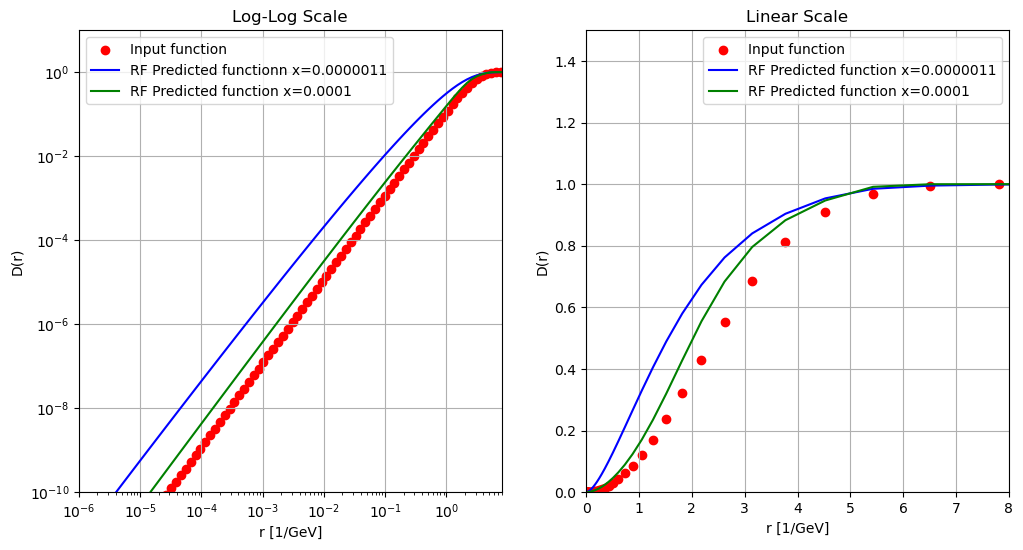

In [6]:
#Example using an input from IPSat:
IPSat_input = dipole(0.01, r, 0., 2.)
output_values = predict(IPSat_input, 0.0000011, 1000)
output_values_2 = predict(IPSat_input, 0.0001, 1000)

# Plot with log-log scale
plt.figure(figsize=(12, 6))

# Plot with log-log scale
plt.subplot(1, 2, 1)
plt.xlim(0.000001, 8.) 
plt.ylim(1e-10, 10.) 
plt.scatter(r, IPSat_input, color='red', label='Input function')
plt.plot(r, output_values, color='blue', label='RF Predicted functionn x=0.0000011')
plt.plot(r, output_values_2, color='green', label='RF Predicted function x=0.0001')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Log-Log Scale')
plt.legend()
plt.grid(True)

# Plot with linear scale
plt.subplot(1, 2, 2)
plt.xlim(0, 8.) 
plt.ylim(0, 1.5) 
plt.scatter(r, IPSat_input, color='red', label='Input function')
plt.plot(r, output_values, color='blue', label='RF Predicted function x=0.0000011')
plt.plot(r, output_values_2, color='green', label='RF Predicted function x=0.0001')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Linear Scale')
plt.legend()
plt.grid(True)

In [37]:
def SaveEvolvedAmplitude(input, filename, C2, x0, xvals):
    '''Save dipole amplitude to a datafile at all different x values
    The format is the same as the output of the rcbk code

    x0: Bjorken-x at the initial condition
    C2: C^2 in the running coupling
    '''
    
    # x values: need to start from the initial condition
    xvals = np.sort(xvals)[::-1]
    if np.abs(np.log(xvals[0]/x0)) > 0.00001:
        print("Largest x value should correspond to the initial condition")
        return

    # check that r_grid has logarithmic spacing
    ratios = [r[i+1]/r[i] for i in range(len(r)-1)]
    if not np.allclose(ratios, [r[1]/r[0]]*(len(r)-1)):
        print("r grid is not logarithmic, can not generate a datafile!")
  
    
    with open(filename,"w") as file:
        file.write("###" + str(r_values[0]) + "\n")
        file.write("###"+str(r_values[1]/r_values[0])+"\n") # step
        file.write("###"+str(len(r_values))+"\n")
        file.write("###"+str(x0)+"\n")

        for x in xvals:
            y = np.log(x0/x)
            file.write("###"+str(y)+"\n")
            dipoles = predict(input, x, C2)
            for d in dipoles:
                file.write(str(d)+"\n")
    file.close()



SaveEvolvedAmplitude(input=IPSat_input,filename="datafile",C2=10,x0=0.01,xvals=np.geomspace(1.001e-6,0.01,6))